In [42]:
# imports
import os
import time

import torch
from torch import Tensor, from_numpy
import numpy as np
import matplotlib.pyplot as plt

from v_prism.data_loading.bullet_reconstruction_dataset import ReconBulletDataset
from v_prism.data_loading.scene import Scene
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid_multiple_objects_w_surface
from v_prism.mapping.v_prism import VPRISM
from v_prism.mapping.bayesian_hilbert_map import BayesianHilbertMapWithFullCovarianceMatrixNoInv
from v_prism.utils.kernels import GaussianKernel
from v_prism.data_loading.negative_sampling import negative_sample_rays_in_sphere_uniform_each_step_multiclass
from v_prism.data_loading.negative_sampling import negative_sample_rays_in_sphere_step_multiclass
from v_prism.data_loading.negative_sampling import add_negative_points_below_plane_multiple_objects
from v_prism.data_loading.negative_sampling import negative_sample_each_ray_for_ablation
from v_prism.utils.ransac import robust_ransac
from v_prism.utils.subsample import grid_subsample, grid_subsample_different_res
from v_prism.utils.ui import abspath
from v_prism.utils.eval import calc_iou, chamfer_dist_for_mesh
from v_prism.utils.pointsdf import PointSDF, scale_and_center_object_points
from v_prism.utils.pointsdf import scale_and_center_queries, index_points
from v_prism.utils.pointsdf import  farthest_point_sample





device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"using device: {device}")

using device: cuda


In [43]:
class VPRISMReconAlgorithm:
    def __init__(
        self, 
        grid_len: float, 
        grid_dist_from_obj: float, 
        kernel_param: float,
        ray_step_size: float,
        object_sphere_radius: float,
        scene_sphere_radius: float,
        subsample_grid_size_occ: float,
        subsample_grid_size_unocc: float,
        num_surface_points_per_obj: int,
        device: torch.device = device
    ) -> None:
        self.grid_len = grid_len
        self.grid_dist_from_obj = grid_dist_from_obj
        self.kernel_param = kernel_param
        self.ray_step_size = ray_step_size
        self.object_sphere_radius = object_sphere_radius
        self.scene_sphere_radius = scene_sphere_radius
        self.subsample_grid_size_occ = subsample_grid_size_occ
        self.subsample_grid_size_unocc = subsample_grid_size_unocc
        self.device = device
        self.num_surface_points = num_surface_points_per_obj
        self.conf = 0.5
        self.vprism_map = None

    def fit(self, scene: Scene) -> None:
        hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
            scene.points, scene.seg_mask, self.grid_len, self.grid_dist_from_obj, self.num_surface_points
        )
        self.hinge_points = hinge_points
        print(f"hinge_points: {hinge_points.shape}")
        kernel = GaussianKernel(self.kernel_param)
        # (2) create map
        vprism_map = VPRISM(
            num_classes=int(torch.amax(scene.seg_mask).item()) + 1,
            hinge_points=hinge_points,
            kernel=kernel,
            num_iterations=3,
            # num_iterations_initial=10
            # num_iterations=5,
        ).to(self.device)
        # (3) neg sampling on data
        scene_center = 0.5 * (
            torch.amax(scene.points[scene.seg_mask > 0], dim=0) 
            + torch.amin(scene.points[scene.seg_mask > 0], dim=0)
        )
        X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
            points=scene.points, 
            mask=scene.seg_mask, 
            step_size=self.ray_step_size, 
            radius=self.object_sphere_radius, 
            camera_pos=scene.camera_pos,
        )
        plane = robust_ransac(scene.points, scene.seg_mask, 100, dist_tol=0.01, radius=self.scene_sphere_radius)
        X, y = add_negative_points_below_plane_multiple_objects(
            X, y, plane=[*list(plane.normal_vect), -plane.bias], center=scene_center, radius=self.object_sphere_radius, k=1000
        )
    
        X, y = grid_subsample_different_res(
            X, 
            y, 
            subsample_grid_size_unocc=self.subsample_grid_size_unocc, 
            subsample_grid_size_occ=self.subsample_grid_size_occ
        )
        print(f"X: {X.shape}")
        # (4) fit bhm
        vprism_map.sequential_update(X.to(self.device), y.to(self.device), 20000)
        self.vprism_map = vprism_map

    def predict(self, x: Tensor) -> Tensor:
        return self.vprism_map.predict(x.to(self.device)).to(torch.device("cpu"))

In [44]:
data_dir = abspath("~/data")
dataset = ReconBulletDataset("bhm4recon_ycb_100", data_dir)
scene_idx = 50  # random scene


In [45]:


def eval_for_grid_len(grid_len):
    algo = VPRISMReconAlgorithm(
        grid_len=grid_len,
        grid_dist_from_obj=0.15,
        kernel_param=1000,
        ray_step_size=0.1,
        object_sphere_radius=0.25,
        subsample_grid_size_occ=0.01,
        subsample_grid_size_unocc=0.015,
        num_surface_points_per_obj=32,
        scene_sphere_radius=0.4,
    )
    res = 0.015
    scene = dataset[scene_idx * dataset.num_views_per]
    start = time.time()
    algo.fit(scene)
    end_fit = time.time()
    print(f"scene {scene_idx} fit in {end_fit - start} seconds.")
    ious = []
    chamfers = []
    for i, obj_data in enumerate(scene.object_metadata):
        mesh_path = os.path.join(data_dir, obj_data["mesh_path"])
        func = lambda x: algo.predict(x)[:, i+1]
        iou = calc_iou(
            mesh_path,
            pred_func=func,
            resolution=res,
            mesh_position=np.array(obj_data["position"]),
            mesh_orientation=np.array(obj_data["orientation"]),
            mesh_scale=np.array(obj_data["scale"]),
            conf=algo.conf,
        )
        chamfer = chamfer_dist_for_mesh(
            mesh_path,
            pred_func=func,
            resolution=res,
            mesh_position=np.array(obj_data["position"]),
            mesh_orientation=np.array(obj_data["orientation"]),
            mesh_scale=np.array(obj_data["scale"]),
            conf=algo.conf,
        )
        ious.append(iou)
        if chamfer is not torch.nan:
            chamfers.append(chamfer)
    avg_iou = sum(ious) / len(ious)
    avg_chamfer = sum(chamfers) / len(chamfers)
    num_hinge = algo.hinge_points.shape[0]
    return avg_iou, avg_chamfer, num_hinge



In [46]:
# grid_lengths = [0.07, 0.065, 0.06, .055, 0.05, 0.045, 0.04]
grid_lengths = [0.2, 0.10, 0.08, 0.06, 0.05, 0.044, 0.04, 0.038]
ious = []
chamfers = []
num_hinges = []

for grid_len in grid_lengths:
    avg_iou, avg_chamfer, num_hinge = eval_for_grid_len(grid_len)
    ious.append(avg_iou)
    chamfers.append(avg_chamfer)
    num_hinges.append(num_hinge)

hinge_points: torch.Size([200, 3])
X: torch.Size([44603, 3])
scene 50 fit in 2.5991146564483643 seconds.


100%|██████████| 27/27 [00:00<00:00, 90.52it/s]


hinge_points: torch.Size([257, 3])
X: torch.Size([44281, 3])
scene 50 fit in 3.308375597000122 seconds.


100%|██████████| 27/27 [00:00<00:00, 66.14it/s]


hinge_points: torch.Size([322, 3])
X: torch.Size([44405, 3])
scene 50 fit in 3.8959810733795166 seconds.


100%|██████████| 27/27 [00:00<00:00, 50.96it/s]


hinge_points: torch.Size([520, 3])
X: torch.Size([44275, 3])
scene 50 fit in 7.062795877456665 seconds.


100%|██████████| 27/27 [00:01<00:00, 25.89it/s]


hinge_points: torch.Size([742, 3])
X: torch.Size([43757, 3])
scene 50 fit in 10.587041854858398 seconds.


100%|██████████| 27/27 [00:01<00:00, 14.79it/s]


hinge_points: torch.Size([996, 3])
X: torch.Size([44199, 3])
scene 50 fit in 18.28012251853943 seconds.


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


hinge_points: torch.Size([1277, 3])
X: torch.Size([44511, 3])
scene 50 fit in 28.2968327999115 seconds.


100%|██████████| 27/27 [00:04<00:00,  5.53it/s]


hinge_points: torch.Size([1455, 3])
X: torch.Size([44011, 3])
scene 50 fit in 37.52718257904053 seconds.


100%|██████████| 27/27 [00:06<00:00,  4.27it/s]


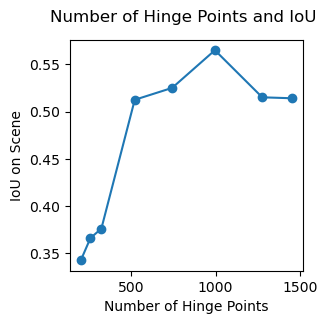

In [48]:
plt.figure(figsize=(3, 3))
plt.scatter(num_hinges, ious)
plt.plot(num_hinges, ious)
plt.xlabel("Number of Hinge Points")
plt.ylabel("IoU on Scene")
plt.suptitle("Number of Hinge Points and IoU")
plt.show()

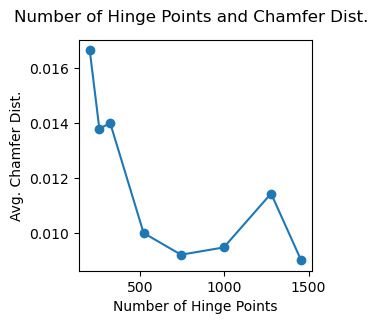

In [50]:
plt.figure(figsize=(3, 3))
plt.scatter(num_hinges, chamfers)
plt.plot(num_hinges, chamfers)
plt.xlabel("Number of Hinge Points")
plt.ylabel("Avg. Chamfer Dist.")
plt.suptitle("Number of Hinge Points and Chamfer Dist.")
plt.show()